In [8]:
import pandas as pd
from scipy.io import loadmat
from dtaidistance import dtw_ndim
from dtaidistance import dtw_ndim_visualisation
from tqdm import tqdm
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn import metrics

In [9]:
#cross数据集
tracks = np.load("../../CROSS_dataset/cross/tracs.npy", allow_pickle=True)
tracks=tracks.reshape(-1)
labels_true = np.load("../../CROSS_dataset/cross/labels.npy", allow_pickle=True)
print(tracks.shape)
print(labels_true.shape)
print(tracks[0].shape)

(200,)
(200,)
(2, 9)


In [17]:
#计算并保存所有track之间的dtw距离矩阵
dis_mat = np.zeros([tracks.shape[0], tracks.shape[0]])
with tqdm(total=tracks.shape[0]) as bar:
    for i, track1 in enumerate(tracks):
        s1 = np.concatenate((track1[0].reshape(-1, 1), track1[1].reshape(-1, 1)), axis=1)
        for j, track2 in enumerate(tracks):   
            if j>=i:          
                s2 = np.concatenate((track2[0].reshape(-1, 1), track2[1].reshape(-1, 1)), axis=1)
                tmp = dtw_ndim.distance(s1, s2)
                dis_mat[i, j] = tmp
                dis_mat[j, i] = tmp
        bar.update(1)
np.save("CROSS_dis_mat.npy",dis_mat)


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


In [16]:
def distance_tracks_means(tracks,means):
    """计算所有track和所有mean之间的距离矩阵"""
    distance_tracks_means=[]
    for track in tracks:
        distance_track_means=[]
        for mean in means:
            s1 = np.concatenate((track[0].reshape(-1, 1), track[1].reshape(-1, 1)), axis=1)
            s2 = np.concatenate((mean[0].reshape(-1, 1), mean[1].reshape(-1, 1)), axis=1)
            dtw=dtw_ndim.distance(s1, s2)
            distance_track_means.append(dtw)
        distance_tracks_means.append(distance_track_means)
    distance_tracks_means=np.array(distance_tracks_means)
    return distance_tracks_means

In [12]:
def mean_of_diverseLenTracks(tracks):
    max_len=0
    for track in tracks:
        if track.shape[1]>max_len:
            max_len=track.shape[1]
    new_tracks=[]
    for track in tracks:
        if track.shape[1]<max_len:
            new_track=[]
            new_track.append(np.concatenate([track[0],np.zeros(max_len-track.shape[1])]))
            new_track.append(np.concatenate([track[1],np.zeros(max_len-track.shape[1])]))
            new_tracks.append(new_track)
    new_tracks=np.array(new_tracks)
    return np.mean(new_tracks,axis=0)
    

In [13]:
def KMeans(tracks, k, tmax=20):
    """对tracks进行K-means聚类，返回各簇的mean（M）和各簇包含的所有track（C）"""
    n = tracks.shape[0]
    if k > n:
        raise Exception('too many clusters')
    
    # 随机初始化k个mean为M
    M_indices = np.arange(n)
    np.random.shuffle(M_indices)
    M_indices = np.sort(M_indices[:k])
    M=tracks[M_indices]
    # M待更新为Mnew
    Mnew = np.copy(M)
    
    D=distance_tracks_means(tracks,M)
    # C[kappa]表示第kappa个cluter的各track的indices
    C = {}
    for i in range(tmax):
        print(f'iteration {i} beginning')
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D, axis=1)
        flag = False
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
            if len(C[kappa]) == 0:
                flag = True
        if flag:
            continue
        # update各cluster的mean
        for kappa in range(k):
            Mnew[kappa] = mean_of_diverseLenTracks(tracks[C[kappa]])
        #如果M不再变化，则收敛了。这里用mean是否一样判断M与Mnew是否完全一样，大概率不会判断错。
        if M.shape==Mnew.shape:
            if np.array_equal(mean_of_diverseLenTracks(M),mean_of_diverseLenTracks(Mnew)):
                break
        M = np.copy(Mnew)
        D=distance_tracks_means(tracks,M)
    else:
        # final update of cluster memberships
        J = np.argmin(D, axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
k= 6 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
k= 7 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
k= 8 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
k= 9 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
k= 10 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
k= 11 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
k= 12 done
The best k: 8, its silhouette_score: 0.29237750410835406


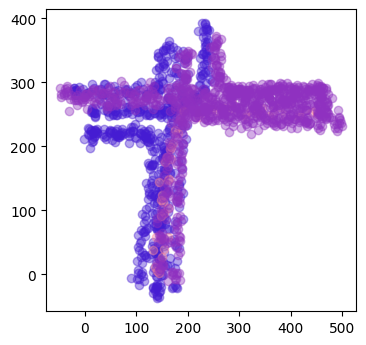

In [14]:
#利用silhouette_score只用5轮迭代选取最优聚类k
best_k = 2
score = -1
distance_mat=np.load("CROSS_dis_mat.npy")
m, n = distance_mat.shape
final_labels = np.zeros((m,))
final_C = []
for k in range(6,13):
    M, C = KMeans(tracks, k,5)
    print('k=',k,'done')
    labels = np.zeros((m,))
    for i in range(k):
        for index in C[i]:
            labels[index] = i
    score_tmp = metrics.silhouette_score(distance_mat, labels)
    if score_tmp > score:
        best_k = k
        final_labels = labels
        score = score_tmp
        final_C = C
print("The best k: {0}, its silhouette_score: {1}".format(best_k, score))
alph=0.4
fig=plt.figure(figsize=(4,4),dpi=100) 
ax=plt.gca()
label_color=[]
for i in range(20):
    label_color+=[[np.random.random(),np.random.random(),np.random.random(),alph],]
ax.cla()
for label_idx in range(best_k):
    for t_idx in C[label_idx]:
        ax.scatter(tracks[t_idx][0], tracks[t_idx][1], color=label_color[label_idx+1])
plt.show()
fig.savefig(f"best_k={best_k}训练着色.png")


The best k: 8
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
iteration 5 beginning
iteration 6 beginning
iteration 7 beginning
iteration 8 beginning
iteration 9 beginning
iteration 10 beginning
iteration 11 beginning
iteration 12 beginning
iteration 13 beginning
iteration 14 beginning
iteration 15 beginning
iteration 16 beginning
iteration 17 beginning
iteration 18 beginning
iteration 19 beginning
ari: 0.15278952437511636
nmi: 0.519604420299515


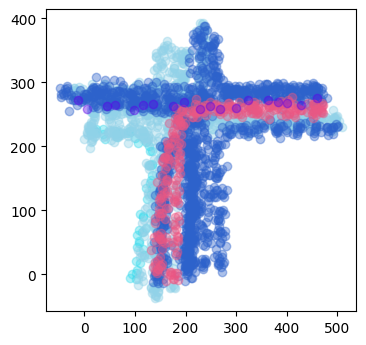

In [15]:
#最终用best_k跑更多轮迭代
print("The best k: {0}".format(best_k))
distance_mat=np.load("CROSS_dis_mat.npy")
m, n = distance_mat.shape
num_iter=20#迭代轮数
M, C= KMeans(tracks, k=best_k,tmax=num_iter)
labels = np.zeros((m,))
for i in range(best_k):
    for index in C[i]:
        labels[index] = i
labels_true = labels_true.flatten()
labels = labels.flatten()
nmi = normalized_mutual_info_score(labels_true,labels)
ari = metrics.adjusted_rand_score(labels_true=labels_true, labels_pred=labels)
print('ari:',ari)
print('nmi:',nmi)

alph=0.4
fig=plt.figure(figsize=(4,4),dpi=100) 
ax=plt.gca()
label_color=[]
for i in range(20):
    label_color+=[[np.random.random(),np.random.random(),np.random.random(),alph],]
ax.cla()
for label_idx in range(best_k):
    for t_idx in C[label_idx]:
        ax.scatter(tracks[t_idx][0], tracks[t_idx][1], color=label_color[label_idx+1])
plt.show()
fig.savefig(f"best_k={best_k}时{num_iter}轮迭代着色.png")